In [2]:
import sys
sys.path.append('/Users/saszco/Desktop/courseWorkDAIS')
import pandas as pd
from config import engine

In [25]:
query = """
        SELECT
            main.dim_region_data.region_name,
            main.dim_year.year,
            main.cancer_analysis.death_cases_count,
            main.cancer_analysis.disease_cases_count,
            main.cancer_analysis.crude_death_rate,
            main.cancer_analysis.crude_disease_rate,
            main.dim_pollution.source_name,
            main.cancer_analysis.pollution_count,
            main.cancer_analysis.population_count
        FROM main.cancer_analysis
        INNER JOIN main.dim_region_data ON main.cancer_analysis.region_info = main.dim_region_data.region_id
        INNER JOIN main.dim_year ON main.cancer_analysis.year_info = main.dim_year.year_id
        INNER JOIN main.dim_pollution ON main.cancer_analysis.pollution_info = main.dim_pollution.pollution_id
        ORDER BY main.dim_region_data.region_name
"""

df = pd.read_sql(query, engine)

In [8]:
df.head(10)

,region_name,year,death_cases_count,disease_cases_count,crude_death_rate,crude_disease_rate,source_name,pollution_count,population_count
0,Івано-Франківська,2021,2084,4135,153.4,304.4,Пересувні джерела,37904.0,1353740
1,Івано-Франківська,2021,2084,4135,153.4,304.4,Стаціонарні джерела,172400.0,1353740
2,Івано-Франківська,2020,2135,3575,156.4,261.8,Стаціонарні джерела,140400.0,1361877
3,Івано-Франківська,2020,2135,3575,156.4,261.8,Пересувні джерела,33090.0,1361877
4,Волинська,2020,1573,2585,152.9,251.3,Пересувні джерела,31669.0,1026681
5,Волинська,2021,1445,2897,141.0,282.7,Стаціонарні джерела,5600.0,1021648
6,Волинська,2020,1573,2585,152.9,251.3,Стаціонарні джерела,5100.0,1026681
7,Волинська,2021,1445,2897,141.0,282.7,Пересувні джерела,30821.0,1021648
8,Вінницька,2020,2466,4361,160.3,283.6,Пересувні джерела,51443.0,1530184
9,Вінницька,2020,2466,4361,160.3,283.6,Стаціонарні джерела,78200.0,1530184


In [26]:
df = df.pivot_table(
    index=['region_name',
           'year',
           'death_cases_count',
           'disease_cases_count',
           'crude_death_rate',
           'crude_disease_rate',
           'population_count'],
    columns='source_name',
    values='pollution_count'       
).reset_index()

df.rename(columns={
    'Пересувні джерела': 'mobile_pollution',
    'Стаціонарні джерела': 'stationary_pollution'
}, inplace=True)

df = df[df['region_name'] != 'Україна']

df.to_csv('working_data.csv', index=False)


In [27]:
df.head(10)

source_name,region_name,year,death_cases_count,disease_cases_count,crude_death_rate,crude_disease_rate,population_count,mobile_pollution,stationary_pollution
0,Івано-Франківська,2020,2135,3575,156.4,261.8,1361877,33090.0,140400.0
1,Івано-Франківська,2021,2084,4135,153.4,304.4,1353740,37904.0,172400.0
2,Волинська,2020,1573,2585,152.9,251.3,1026681,31669.0,5100.0
3,Волинська,2021,1445,2897,141.0,282.7,1021648,30821.0,5600.0
4,Вінницька,2020,2466,4361,160.3,283.6,1530184,51443.0,78200.0
5,Вінницька,2021,2314,4600,152.0,302.2,1512234,55155.0,79300.0
6,Дніпропетровська,2020,3937,9715,124.1,306.1,3156032,126006.0,534700.0
7,Дніпропетровська,2021,4034,10242,128.5,326.3,3115951,133461.0,537600.0
8,Донецька,2020,2235,4168,54.5,101.6,4103159,51491.0,751000.0
9,Донецька,2021,3058,6534,75.2,160.7,4066941,51334.0,744100.0


<h1>Досліджую кореляцію</h1>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Теплова карта кореляцій, 2020')

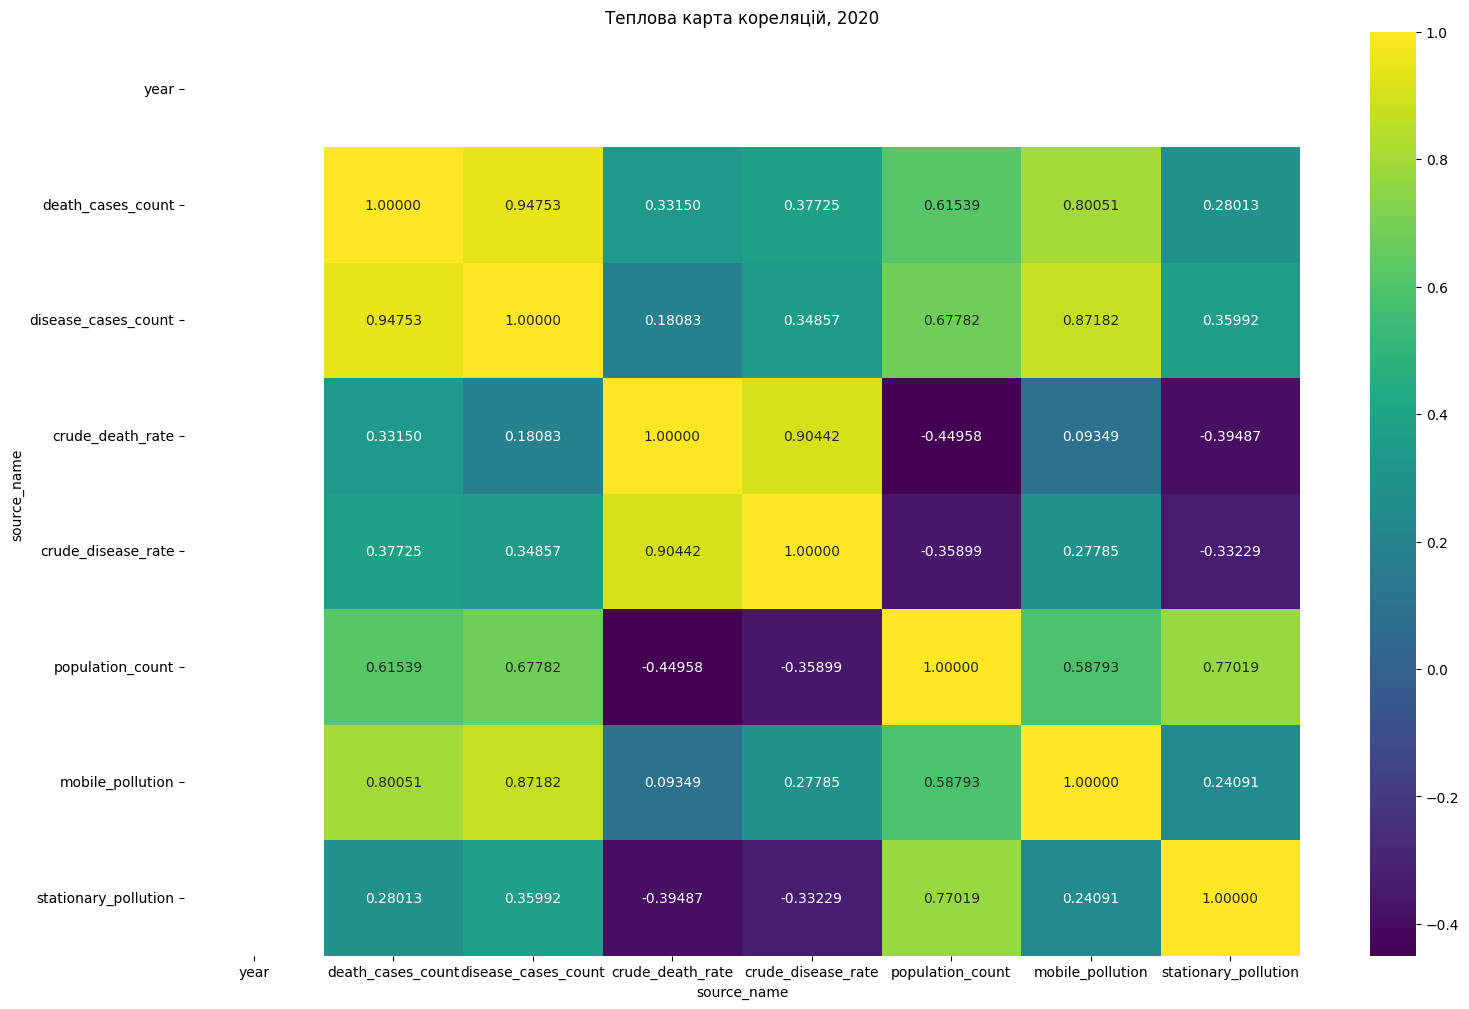

In [97]:
corr_matrix_2020 = df[df['year'] == 2020].corr(numeric_only=True)
plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix_2020, annot=True, cmap='viridis', fmt='.5f')
plt.title('Теплова карта кореляцій, 2020')


Text(0.5, 1.0, 'Теплова карта кореляцій, 2021')

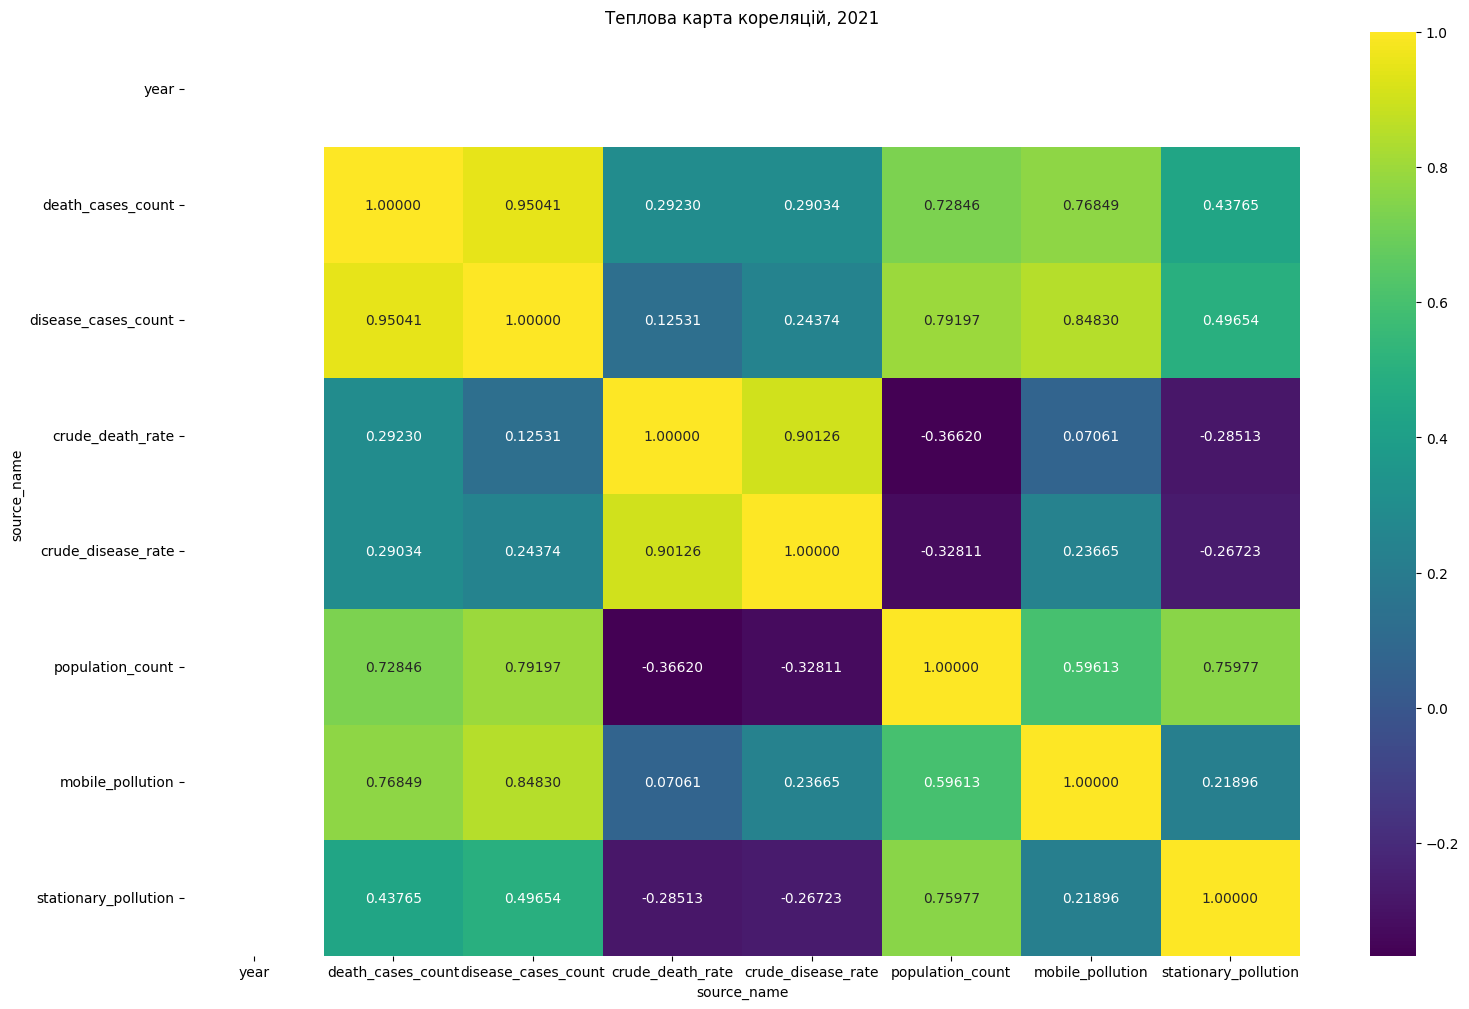

In [99]:
corr_matrix_2021 = df[df['year'] == 2021].corr(numeric_only=True)
plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix_2021, annot=True, cmap='viridis', fmt='.5f')
plt.title('Теплова карта кореляцій, 2021')

<p>Бачу, що між ознаками mobile_polution та death_cases_count / disease_cases_count є кореляція</p>
<p>між population_count та stationary_pollution, population_count та mobile_pollution є кореляція</p>

<h1>Будую графіки лінійної регресії</h1>

In [101]:
x_vars=['death_cases_count', 'disease_cases_count', 'population_count']

def multiple_regplot(axes, x_vars, y_col, df, year):
    for ax, x_vars in zip(axes, x_vars):
        sns.regplot(x=x_vars, y=y_col, data=df, ax=ax)
        ax.set_title(f'{x_vars} and {y_col} {year}')

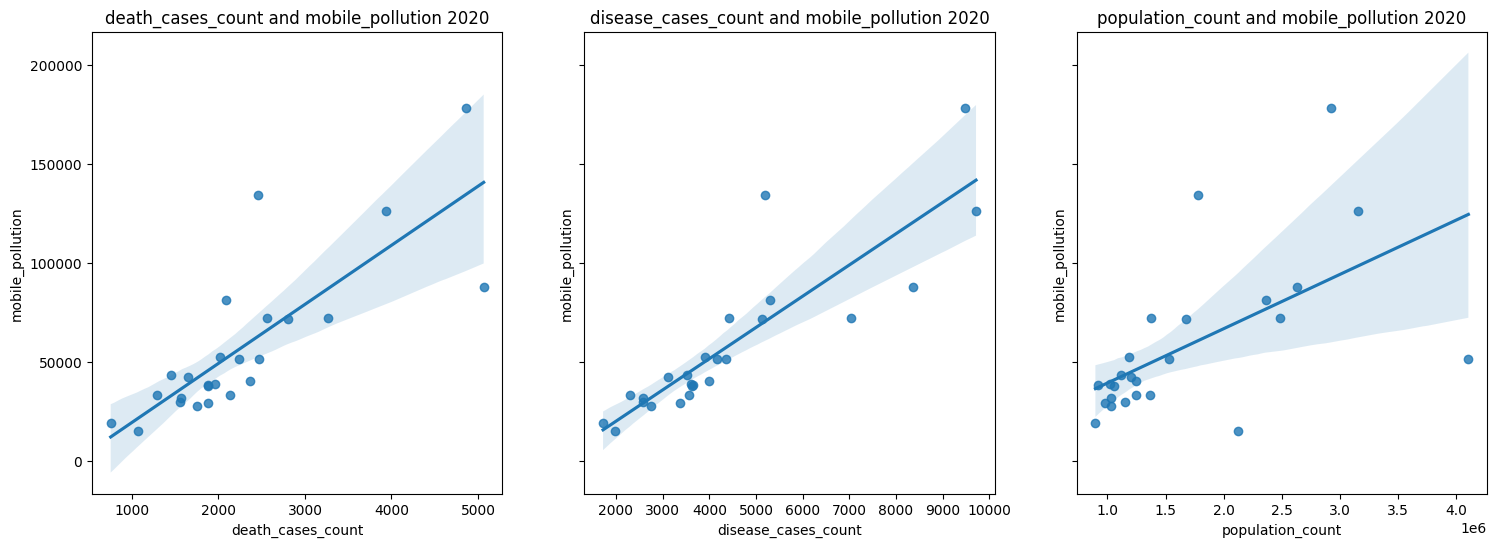

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
multiple_regplot(axes, x_vars, 'mobile_pollution', df[df['year'] == 2020], '2020')

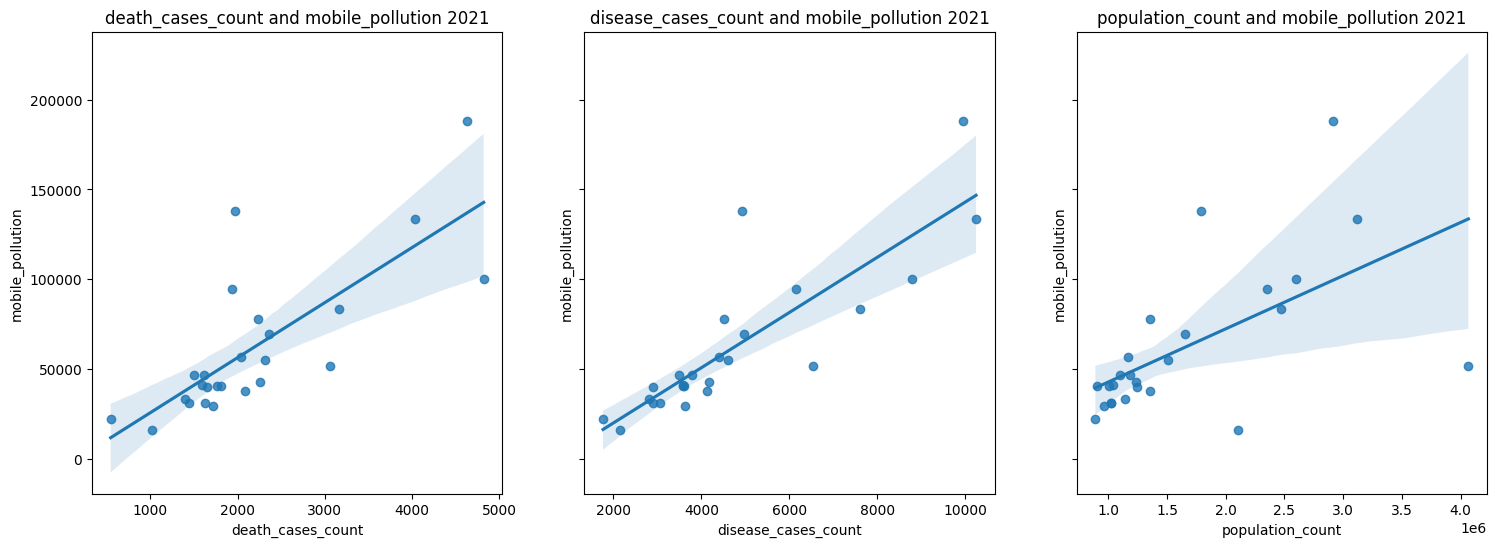

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
multiple_regplot(axes, x_vars, 'mobile_pollution', df[df['year'] == 2021], '2021')

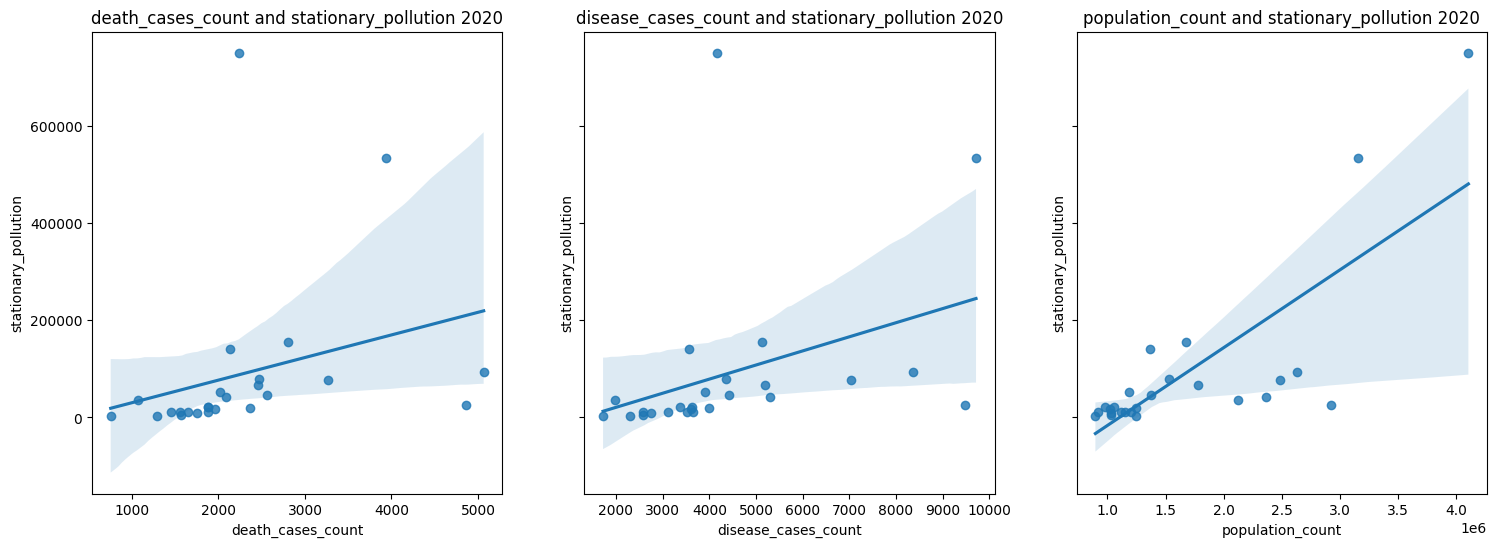

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
multiple_regplot(axes, x_vars, 'stationary_pollution', df[df['year'] == 2020], '2020')

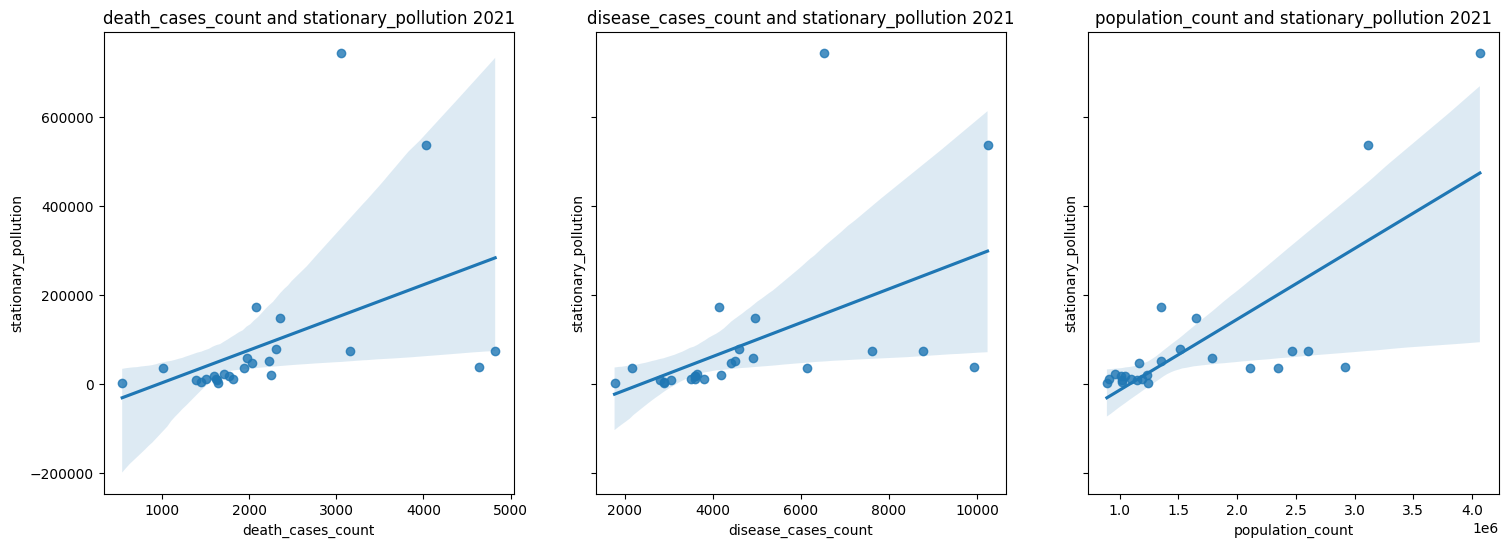

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
multiple_regplot(axes, x_vars, 'stationary_pollution', df[df['year'] == 2021], '2021')

<h1>Коефіцієнт кореляції Пірсона, P-value для кількісних змінних</h1>

In [ ]:
%pip install scipy

In [107]:
from scipy import stats

def pearson_corr(feature, column, df):
    pearson_coef, p_value = stats.pearsonr(df[feature], df[column])
    print(f'{feature} VS {column}')
    print('Pearson: {:.5f}'.format(pearson_coef))
    print('P-value: {:.5g}'.format(p_value))

In [51]:
features = ['death_cases_count', 'disease_cases_count', 'population_count']

In [108]:
for feature in features:
    pearson_corr(feature, 'mobile_pollution', df[df['year'] == 2020])

death_cases_count VS mobile_pollution
Pearson: 0.80051
P-value: 1.5485e-06
disease_cases_count VS mobile_pollution
Pearson: 0.87182
P-value: 1.3852e-08
population_count VS mobile_pollution
Pearson: 0.58793
P-value: 0.0019966


In [109]:
for feature in features:
    pearson_corr(feature, 'mobile_pollution', df[df['year'] == 2021])

death_cases_count VS mobile_pollution
Pearson: 0.76849
P-value: 7.2331e-06
disease_cases_count VS mobile_pollution
Pearson: 0.84830
P-value: 8.5213e-08
population_count VS mobile_pollution
Pearson: 0.59613
P-value: 0.001662


In [110]:
for feature in features:
    pearson_corr(feature, 'stationary_pollution', df[df['year'] == 2020])

death_cases_count VS stationary_pollution
Pearson: 0.28013
P-value: 0.17501
disease_cases_count VS stationary_pollution
Pearson: 0.35992
P-value: 0.077189
population_count VS stationary_pollution
Pearson: 0.77019
P-value: 6.7072e-06


In [111]:
for feature in features:
    pearson_corr(feature, 'stationary_pollution', df[df['year'] == 2021])

death_cases_count VS stationary_pollution
Pearson: 0.43765
P-value: 0.028673
disease_cases_count VS stationary_pollution
Pearson: 0.49654
P-value: 0.011578
population_count VS stationary_pollution
Pearson: 0.75977
P-value: 1.0561e-05


<h1>Box plots</h1>

In [65]:
def box_plot(x_val, y_val, df, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_val, y=y_val, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

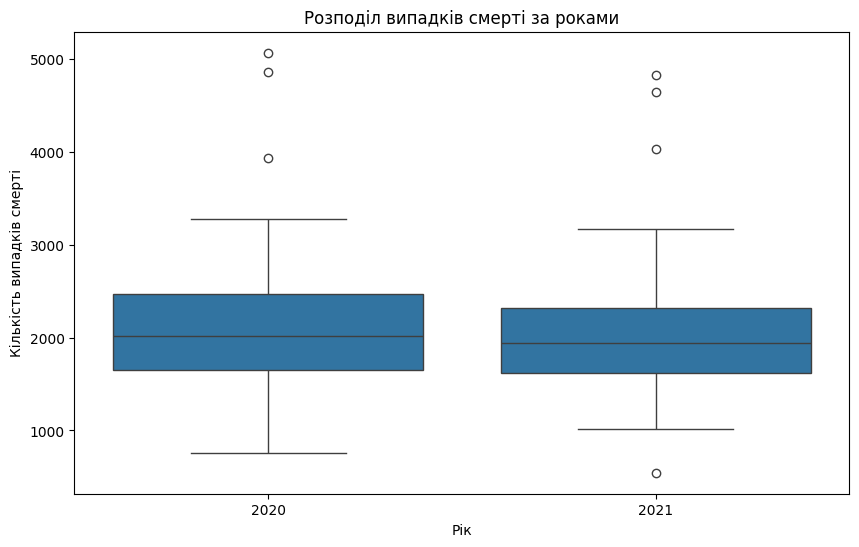

In [66]:
box_plot('year', 'death_cases_count', df, 'Розподіл випадків смерті за роками', 'Рік', 'Кількість випадків смерті')

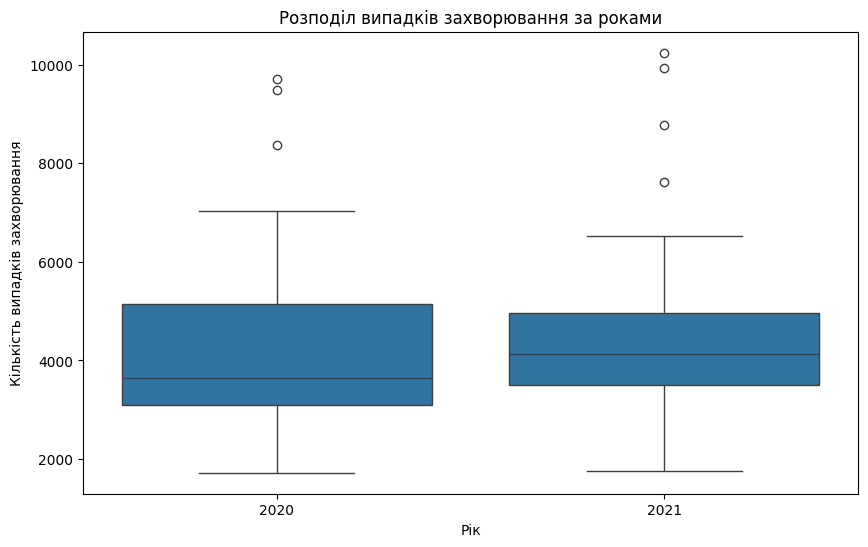

In [67]:
box_plot('year', 'disease_cases_count', df, 'Розподіл випадків захворювання за роками', 'Рік', 'Кількість випадків захворювання')

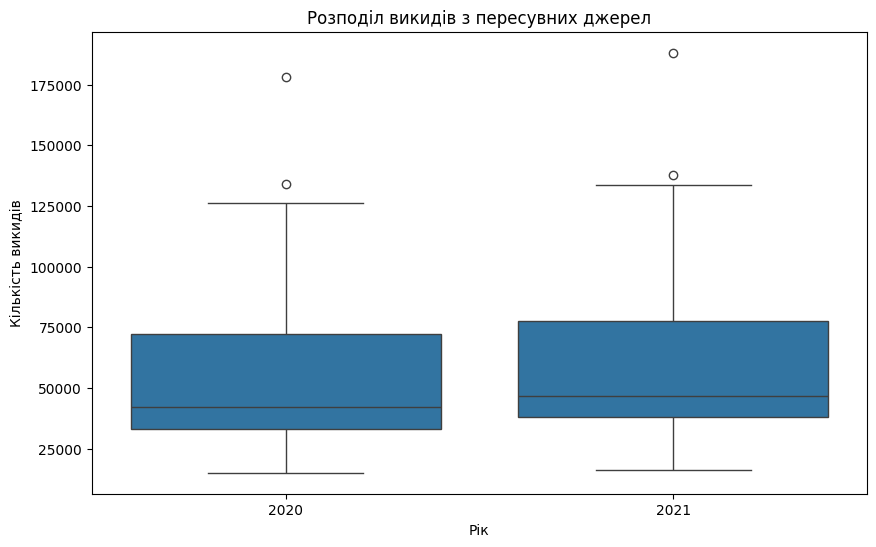

In [68]:
box_plot('year', 'mobile_pollution', df, 'Розподіл викидів з пересувних джерел', 'Рік', 'Кількість викидів')

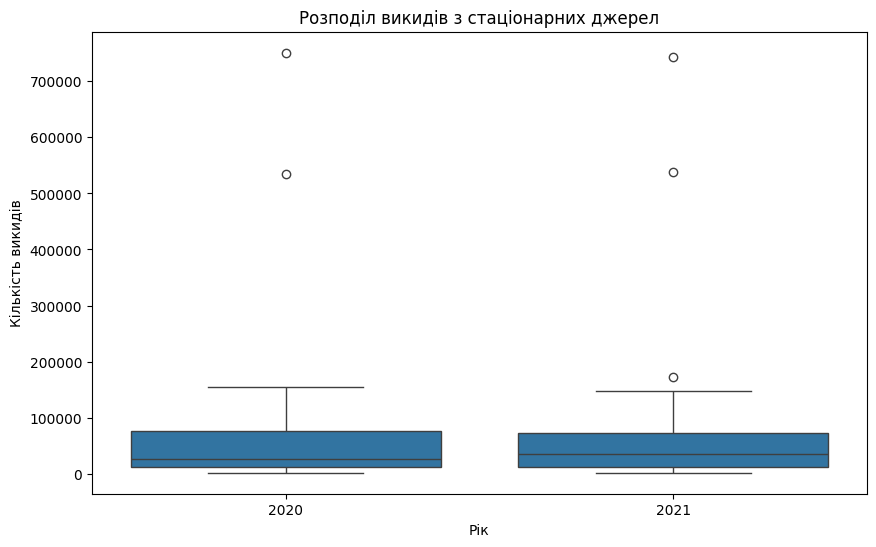

In [69]:
box_plot('year', 'stationary_pollution', df, 'Розподіл викидів з стаціонарних джерел', 'Рік', 'Кількість викидів')

In [79]:
def chart_plt(x_name, y_name,y2_name, df, label, label2):
    plt.figure(figsize=(18,8))
    sns.barplot(x=x_name, y=y_name, data=df, color='skyblue', label=label)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')

    plt2 = plt.twinx()
    sns.lineplot(x=x_name, y=y2_name, data=df, color='red', ax=plt2, label=label2)
    plt2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

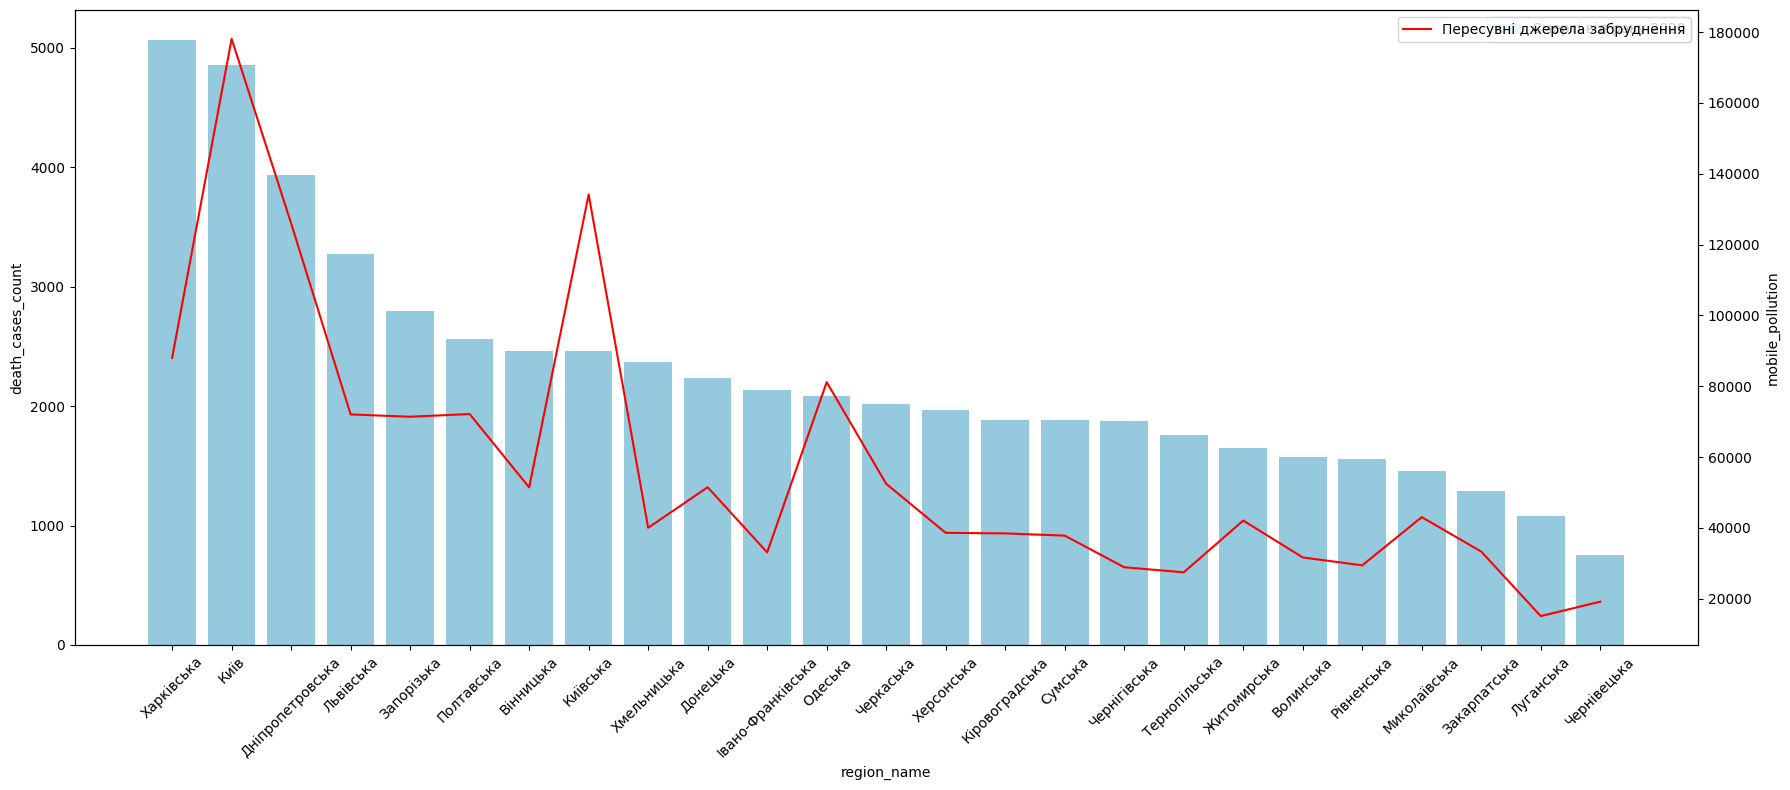

In [80]:
chart_plt('region_name', 'death_cases_count', 'mobile_pollution', df[df['year'] == 2020].sort_values(by='death_cases_count', ascending=False), 'Смерті від раку 2020', 'Пересувні джерела забруднення')

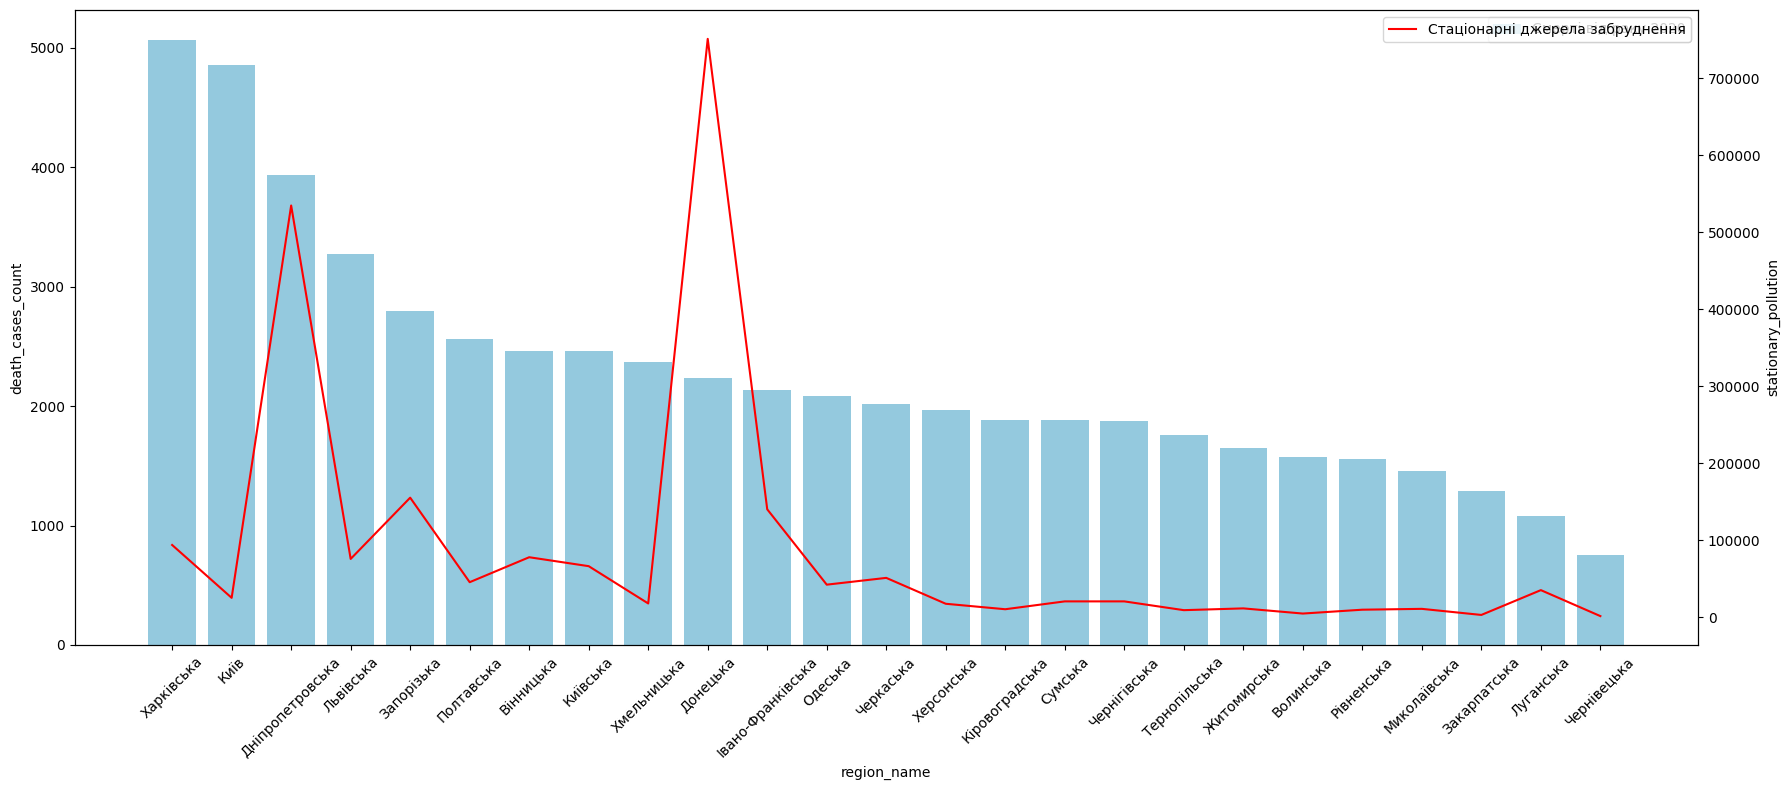

In [82]:
chart_plt('region_name', 'death_cases_count', 'stationary_pollution', df[df['year'] == 2020].sort_values(by='death_cases_count', ascending=False), 'Смерті від раку 2020', 'Стаціонарні джерела забруднення')

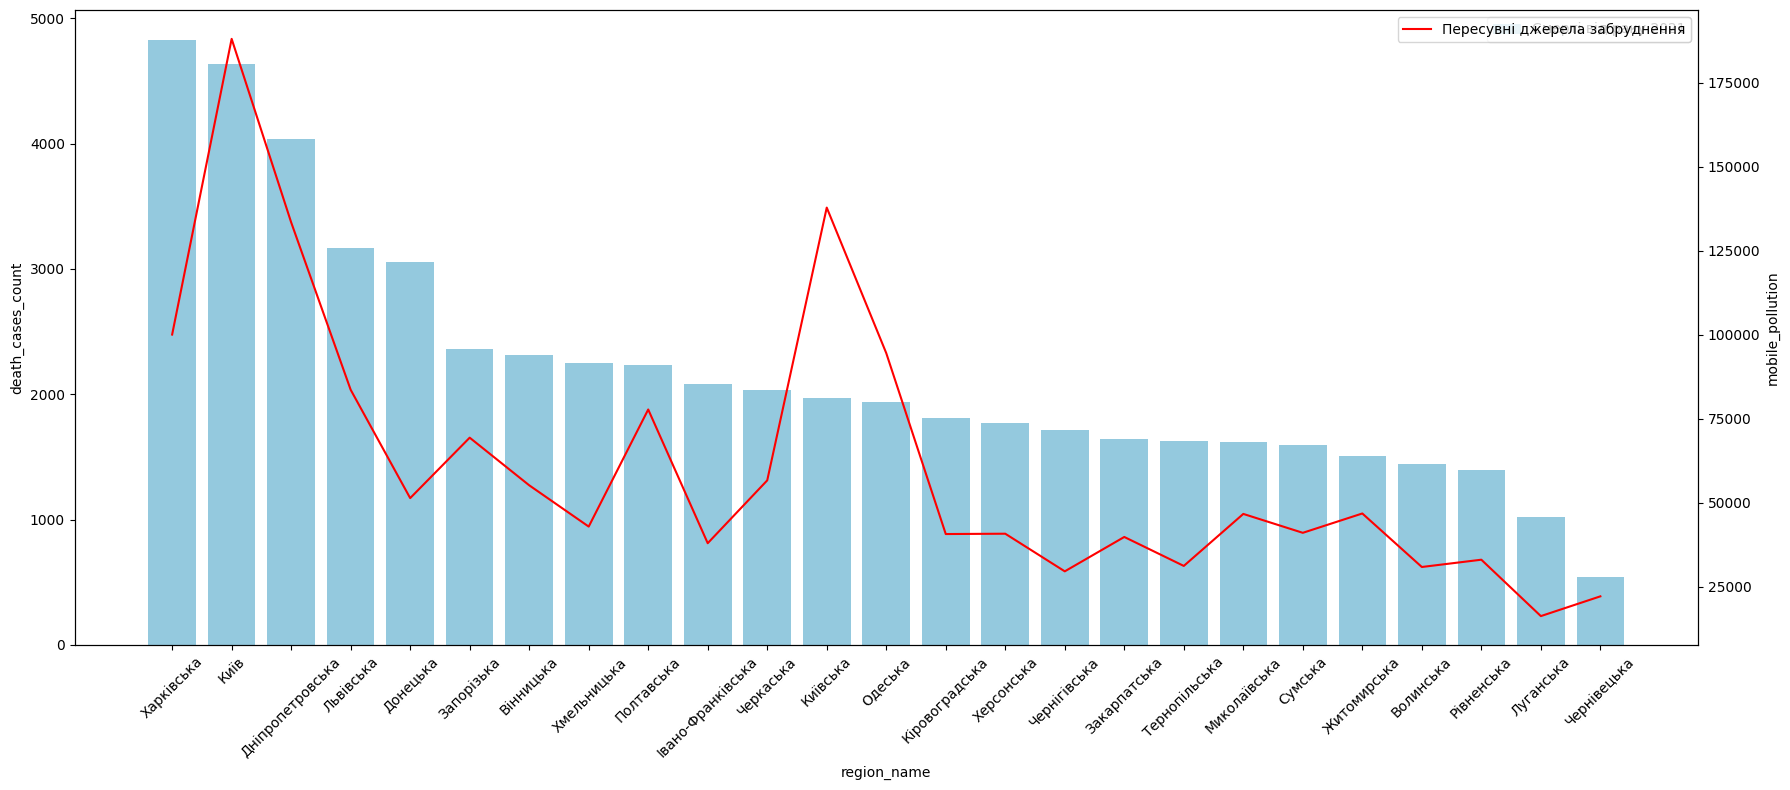

In [83]:
chart_plt('region_name', 'death_cases_count', 'mobile_pollution', df[df['year'] == 2021].sort_values(by='death_cases_count', ascending=False), 'Смерті від раку 2021', 'Пересувні джерела забруднення')

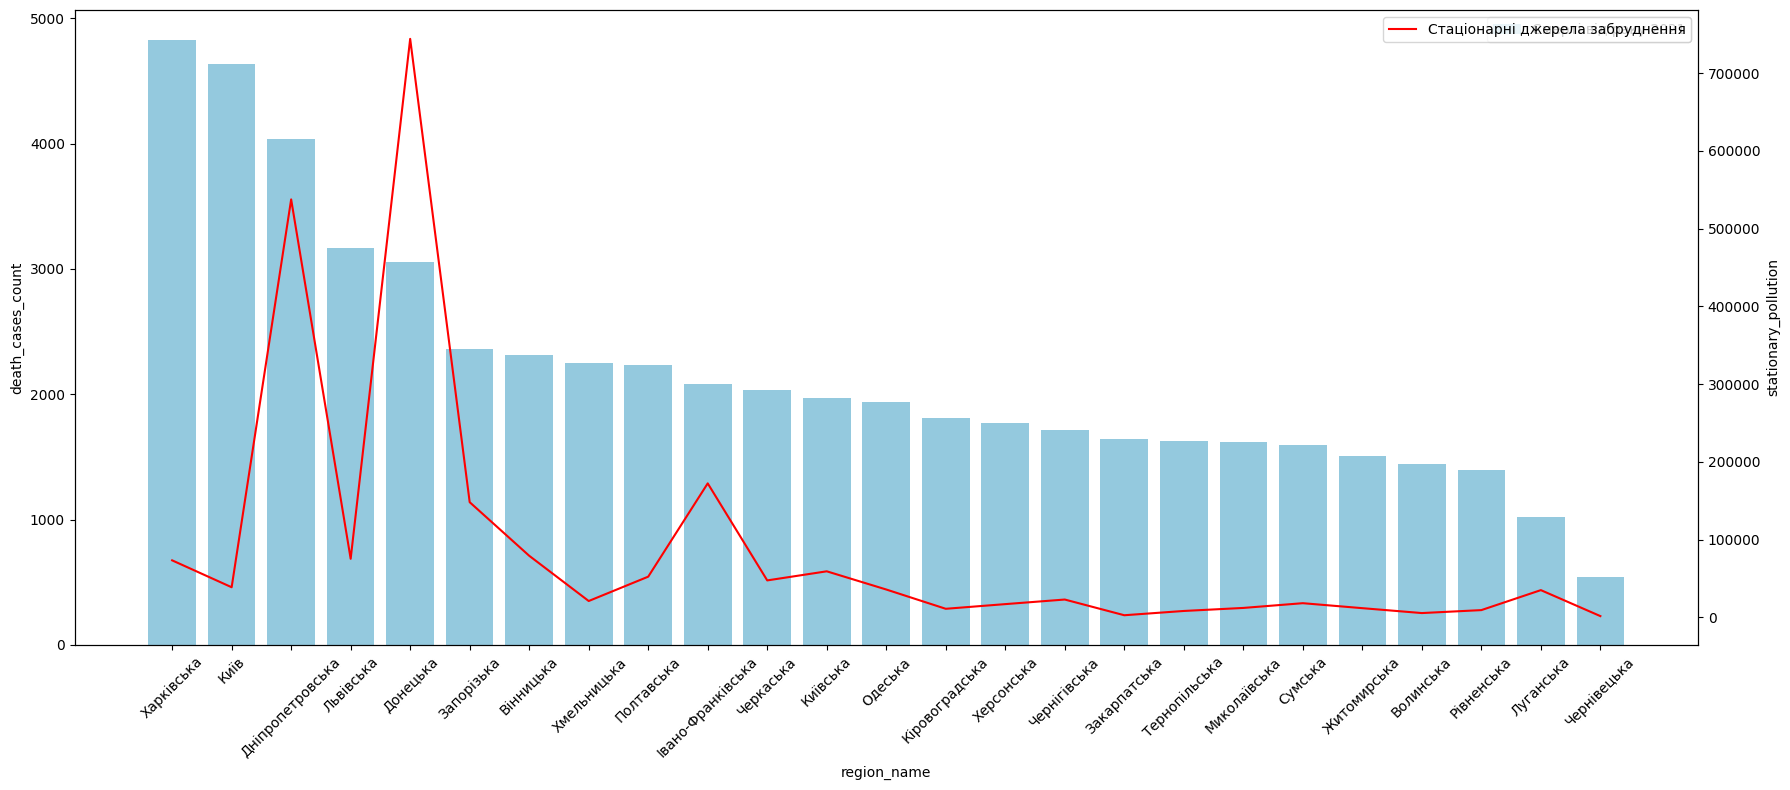

In [84]:
chart_plt('region_name', 'death_cases_count', 'stationary_pollution', df[df['year'] == 2021].sort_values(by='death_cases_count', ascending=False), 'Смерті від раку 2021', 'Стаціонарні джерела забруднення')

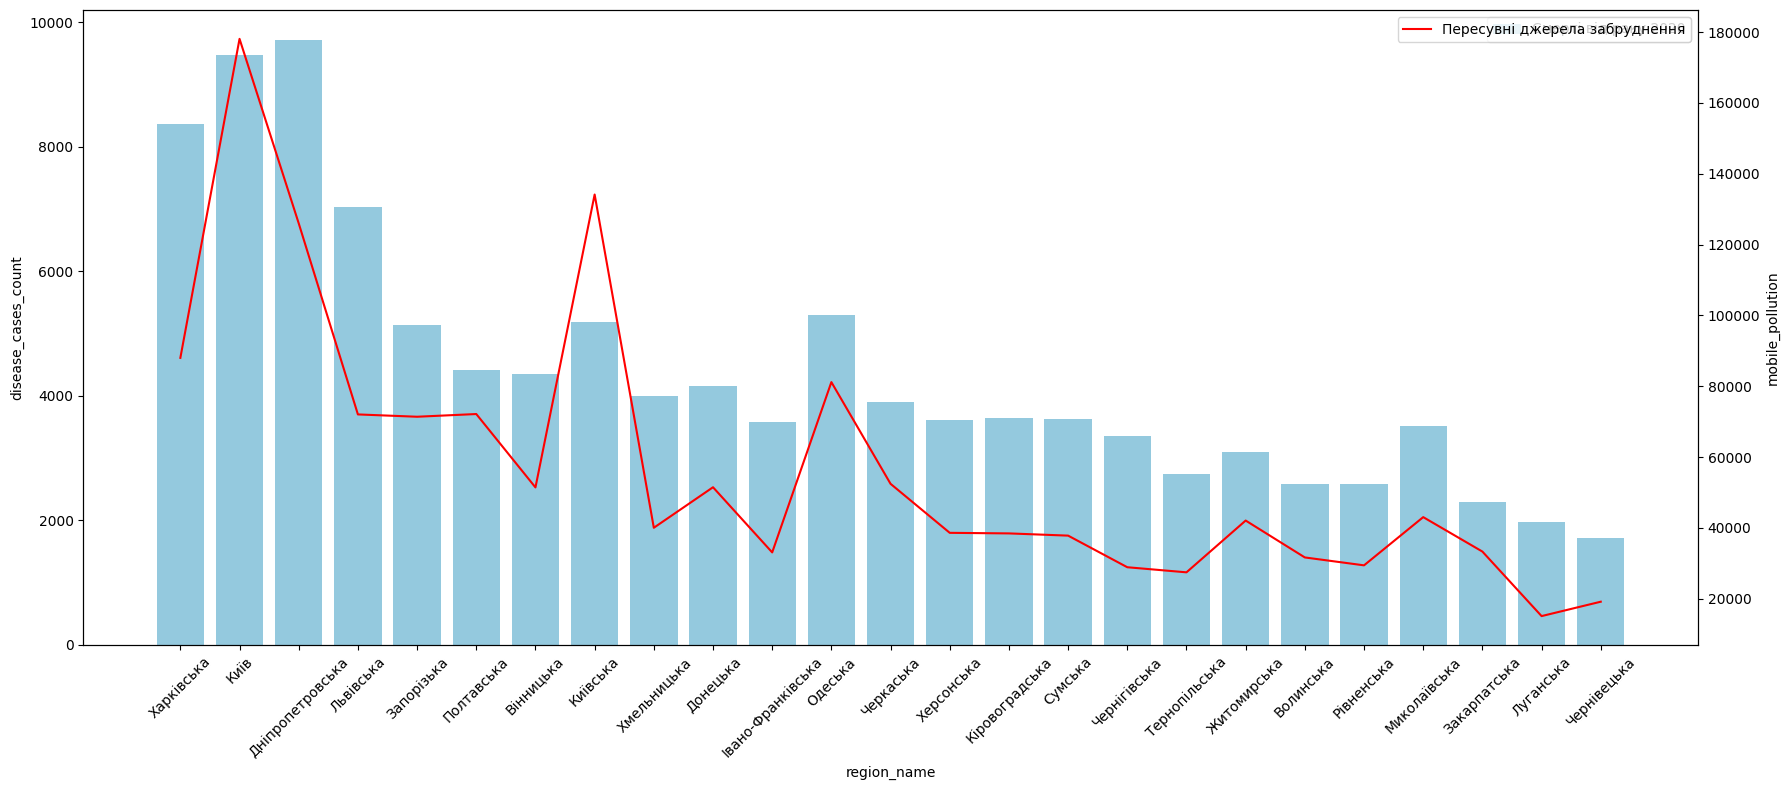

In [85]:
chart_plt('region_name', 'disease_cases_count', 'mobile_pollution', df[df['year'] == 2020].sort_values(by='death_cases_count', ascending=False), 'Захворюваність на рак 2020', 'Пересувні джерела забруднення')

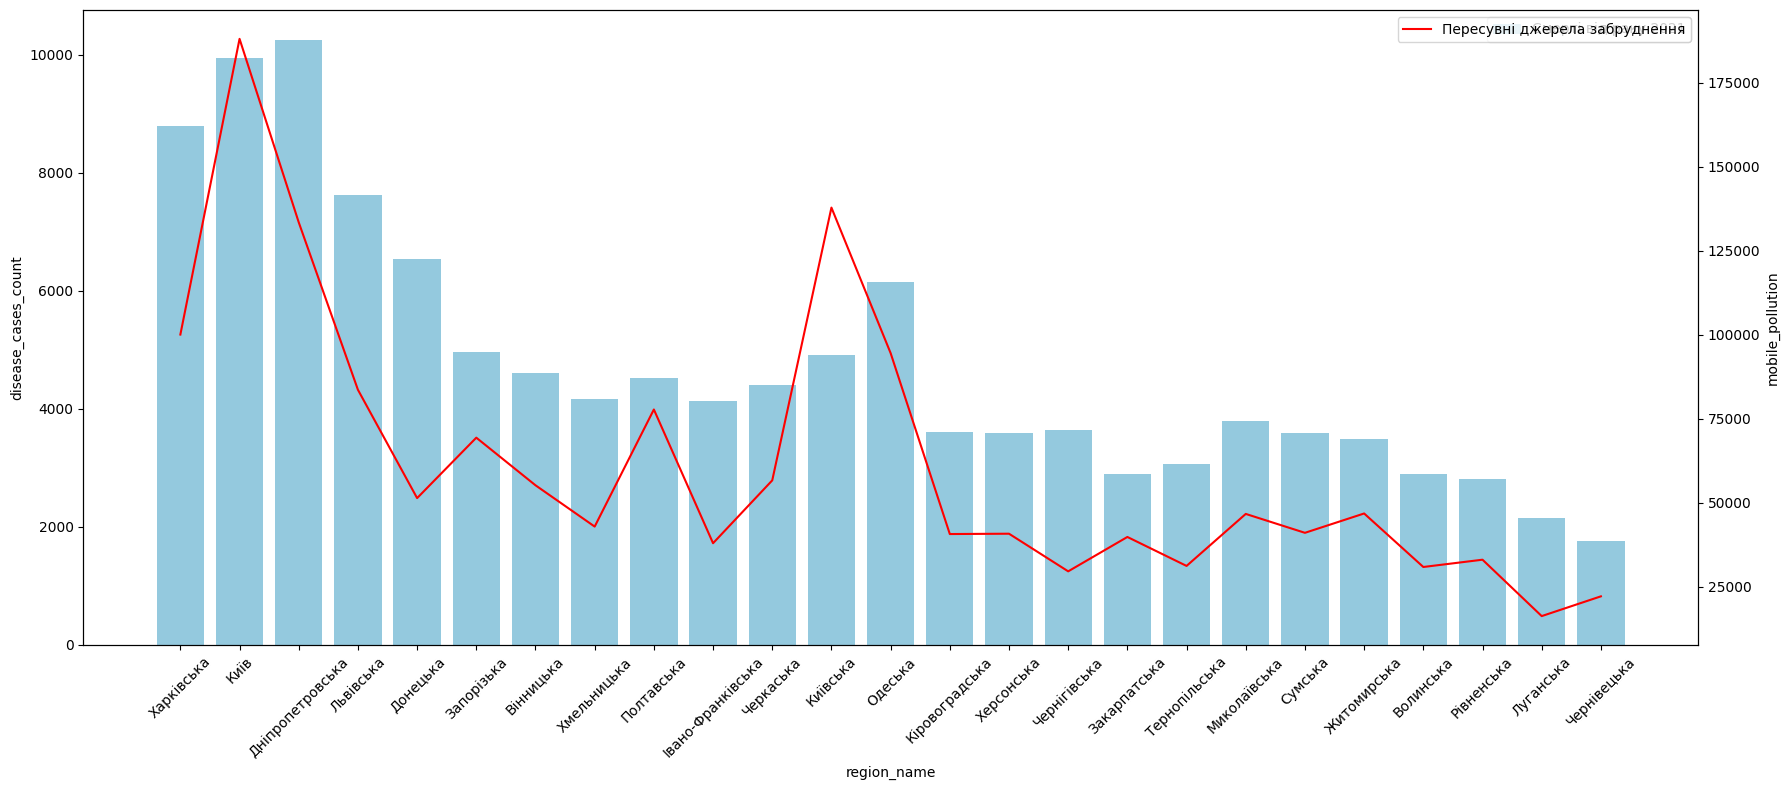

In [ ]:
chart_plt('region_name', 'disease_cases_count', 'mobile_pollution', df[df['year'] == 2021].sort_values(by='death_cases_count', ascending=False), 'Захворюваність на рак 2021', 'Пересувні джерела забруднення')

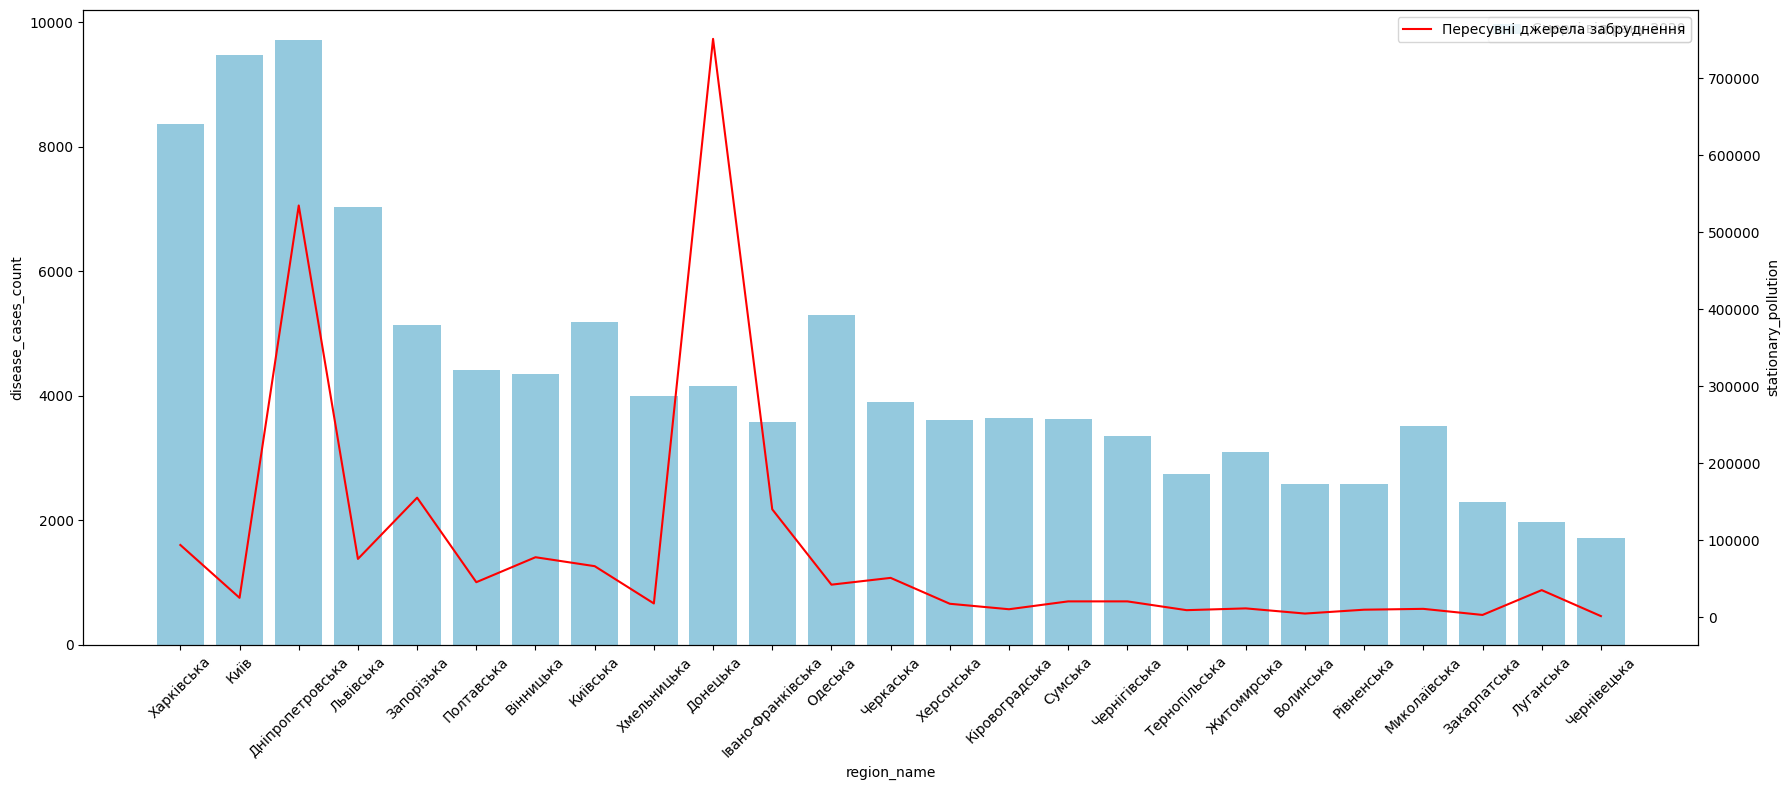

In [88]:
chart_plt('region_name', 'disease_cases_count', 'stationary_pollution', df[df['year'] == 2020].sort_values(by='death_cases_count', ascending=False), 'Захворюваність на рак 2020', 'Стаціонарні джерела забруднення')

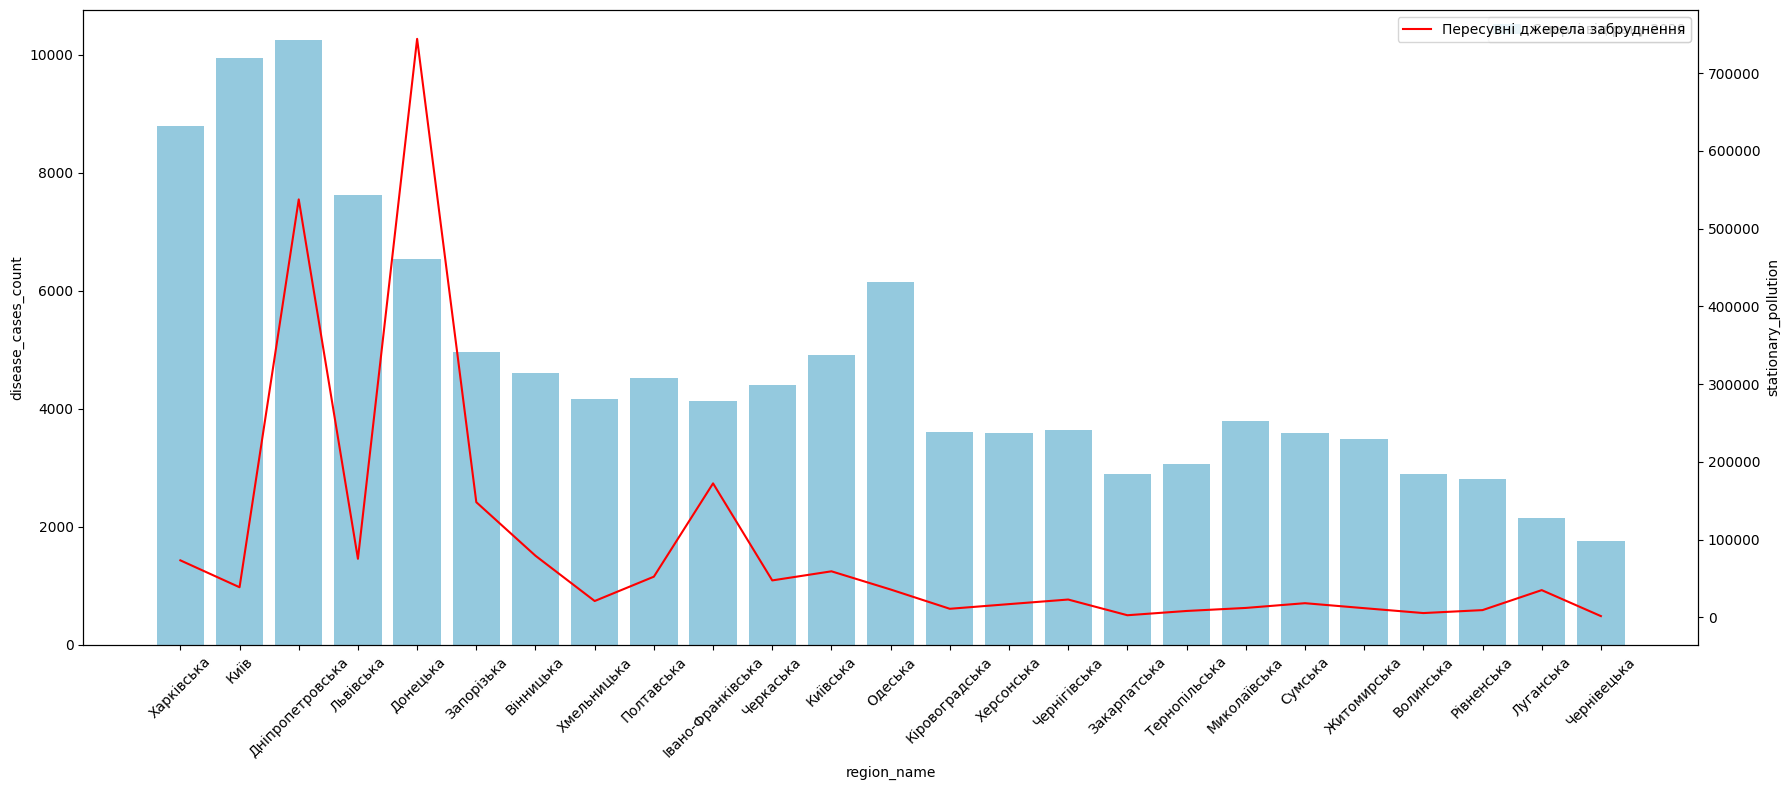

In [89]:
chart_plt('region_name', 'disease_cases_count', 'stationary_pollution', df[df['year'] == 2021].sort_values(by='death_cases_count', ascending=False), 'Захворюваність на рак 2020', 'Стаціонарні джерела забруднення')

<h1>Кластерний аналіз</h1>

In [ ]:
%pip install scikit-learn

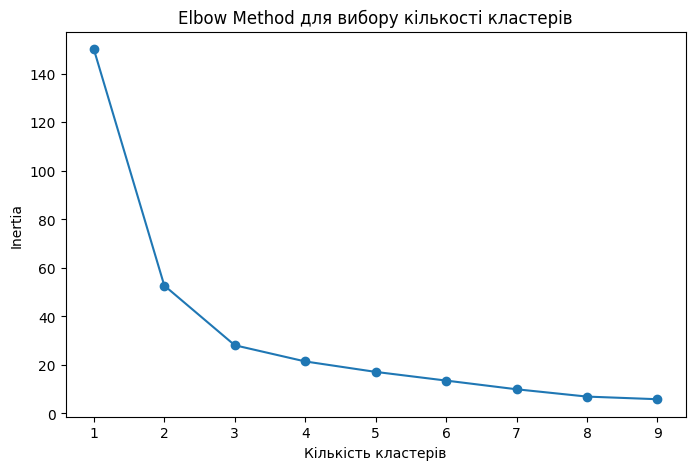

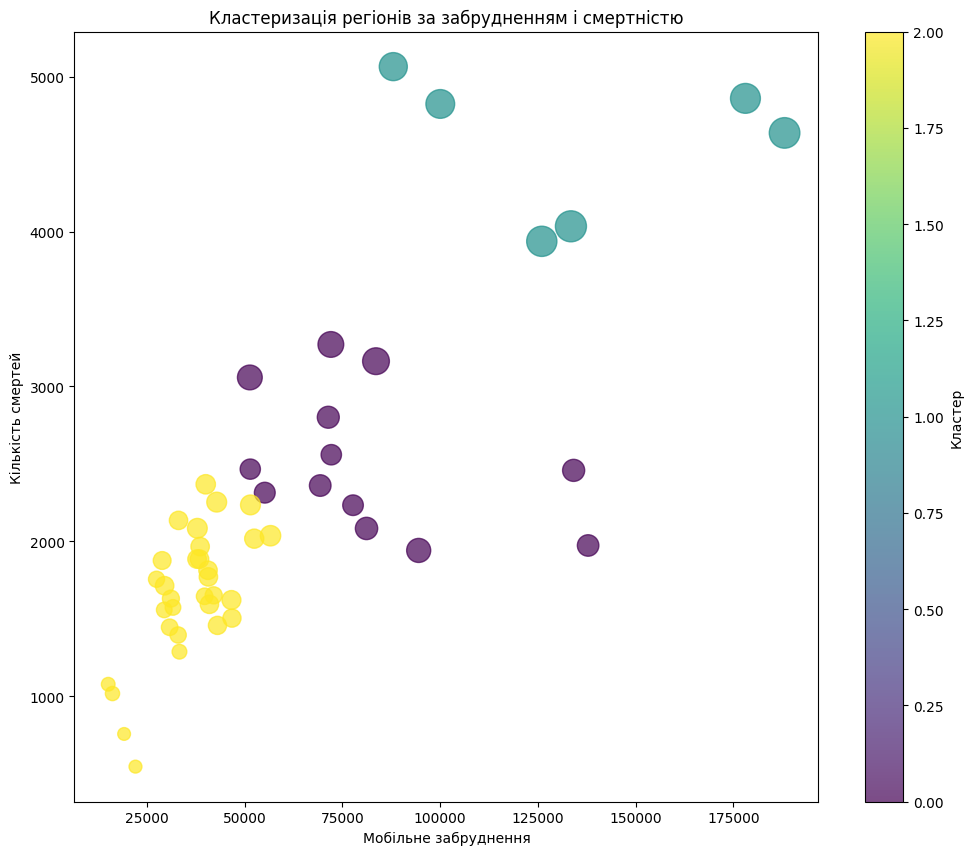


Кластер 0:
['Вінницька' 'Вінницька' 'Донецька' 'Запорізька' 'Запорізька' 'Київська'
 'Київська' 'Львівська' 'Львівська' 'Одеська' 'Одеська' 'Полтавська'
 'Полтавська']

Кластер 1:
['Дніпропетровська' 'Дніпропетровська' 'Київ' 'Київ' 'Харківська'
 'Харківська']

Кластер 2:
['Івано-Франківська' 'Івано-Франківська' 'Волинська' 'Волинська'
 'Донецька' 'Житомирська' 'Житомирська' 'Закарпатська' 'Закарпатська'
 'Кіровоградська' 'Кіровоградська' 'Луганська' 'Луганська' 'Миколаївська'
 'Миколаївська' 'Рівненська' 'Рівненська' 'Сумська' 'Сумська'
 'Тернопільська' 'Тернопільська' 'Херсонська' 'Херсонська' 'Хмельницька'
 'Хмельницька' 'Черкаська' 'Черкаська' 'Чернівецька' 'Чернівецька'
 'Чернігівська' 'Чернігівська']

Кластер 3:
[]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Вибір ознак для кластеризації
features1 = df[['mobile_pollution', 'death_cases_count', 'disease_cases_count']]

# Масштабування даних
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features1)

# Вибір оптимальної кількості кластерів (метод "ліктя")
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method для вибору кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Inertia')
plt.show()

# Кластеризація з обраною кількістю кластерів (припустимо, 4)
kmeans1 = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42)
kmeans1.fit(features_scaled)
df['cluster'] = kmeans1.labels_

# Візуалізація
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df['mobile_pollution'], df['death_cases_count'], 
                      s=df['disease_cases_count'] / df['disease_cases_count'].max() * 500,  # Нормалізація розміру
                      c=df['cluster'], alpha=0.7)  # Use 'cluster' column for coloring
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Мобільне забруднення')
plt.ylabel('Кількість смертей')
plt.title('Кластеризація регіонів за забрудненням і смертністю')
plt.show()

# Виведення регіонів у кожному кластері
for cluster in range(3):
    print(f"\nКластер {cluster}:")
    print(df[df['cluster'] == cluster]['region_name'].values)

<h1>Linear Regression</h1>

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = df['disease_cases_count']
x = df[['mobile_pollution', 'stationary_pollution']]

In [165]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print("Number of test samples: ", x_test.shape[0])
print("Number of training samples: ", x_train.shape[0])

Number of test samples:  10
Number of training samples:  40


In [166]:
model1 = LinearRegression()

In [167]:
model1.fit(x_train[['mobile_pollution']], y_train)

LinearRegression()

In [168]:
print('R^2 with train data: ', model1.score(x_train[['mobile_pollution']], y_train))
print('R^2 with test data: ', model1.score(x_test[['mobile_pollution']], y_test))

R^2 with train data:  0.7337829668834832
R^2 with test data:  0.7587344584559328


<h1>----------------------------------</h1>

In [169]:
model2 = LinearRegression()

In [170]:
model2.fit(x_train[['stationary_pollution']], y_train)

LinearRegression()

In [171]:
print('R^2 with train data: ', model2.score(x_train[['stationary_pollution']], y_train))
print('R^2 with test data: ', model2.score(x_test[['stationary_pollution']], y_test))

R^2 with train data:  0.3059338865295169
R^2 with test data:  -1.008069796855981


<h2>MSE</h2>

In [173]:
y_predicted = model1.predict(x_test[['mobile_pollution']])

In [174]:
from sklearn.metrics import mean_squared_error

mse1 = mean_squared_error(y_test, y_predicted)

In [175]:
print(f'MSE для mobile_pollution: {mse1:.2f}')

MSE для mobile_pollution: 745213.64


In [176]:
y_predicted2 = model2.predict(x_test[['stationary_pollution']])

In [177]:
mse2 = mean_squared_error(y_test, y_predicted2)

In [178]:
print(f'MSE для stationary_pollution: {mse2:.2f}')

MSE для stationary_pollution: 6202464.72


У мене є показники "Грубий показник захворюваності та смертності на 100 тис. населення". Зараз я порахую показники кількість викидів на 100 тис. населення, і тоді проведу аналіз між цими ознаками

In [197]:
df['mp_rate'] = 0; #mobile pollution per 100k of population
df['sp_rate'] = 0; #stationary pollution per 100k of population

df = df.astype({"mp_rate": "float", "sp_rate": "float"})

def count_rates(column1, column2, new_column):
    for index, row in df.iterrows():
        value1 = row[column1]
        value2 = row[column2]
        rate = value1 * 100000 / value2
        df.at[index, new_column] = round(rate, 2)


In [198]:
df.dtypes

source_name
region_name              object
year                      int64
death_cases_count         int64
disease_cases_count       int64
crude_death_rate        float64
crude_disease_rate      float64
population_count          int64
mobile_pollution        float64
stationary_pollution    float64
cluster                   int32
mp_rate                 float64
sp_rate                 float64
dtype: object

In [199]:
count_rates('mobile_pollution', 'population_count', 'mp_rate')

In [201]:
count_rates('stationary_pollution', 'population_count', 'sp_rate')

In [202]:
df.head()

source_name,region_name,year,death_cases_count,disease_cases_count,crude_death_rate,crude_disease_rate,population_count,mobile_pollution,stationary_pollution,cluster,mp_rate,sp_rate
0,Івано-Франківська,2020,2135,3575,156.4,261.8,1361877,33090.0,140400.0,2,2429.73,10309.30
1,Івано-Франківська,2021,2084,4135,153.4,304.4,1353740,37904.0,172400.0,2,2799.95,12735.09
2,Волинська,2020,1573,2585,152.9,251.3,1026681,31669.0,5100.0,2,3084.60,496.75
3,Волинська,2021,1445,2897,141.0,282.7,1021648,30821.0,5600.0,2,3016.79,548.13
4,Вінницька,2020,2466,4361,160.3,283.6,1530184,51443.0,78200.0,0,3361.88,5110.50


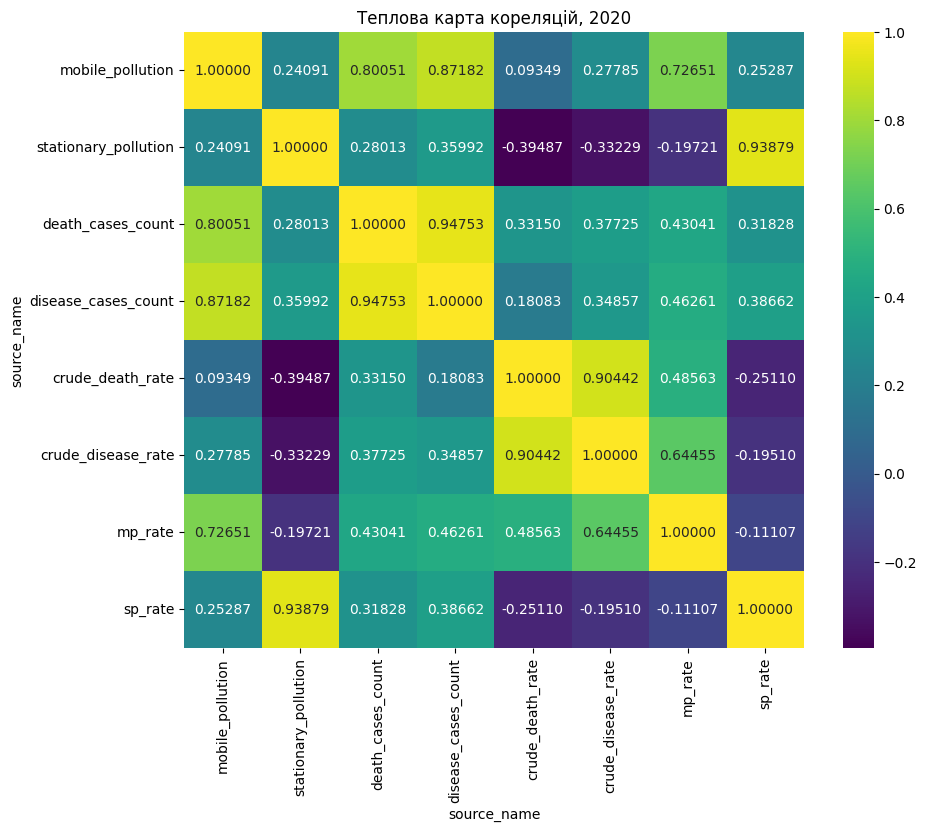

In [207]:
selected_features = ['mobile_pollution', 'stationary_pollution', 'death_cases_count', 
                    'disease_cases_count', 'crude_death_rate', 'crude_disease_rate', 
                    'mp_rate', 'sp_rate']

corr_matrix_2020_1 = df[df['year'] == 2020][selected_features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_2020_1, annot=True, cmap='viridis', fmt='.5f')
plt.title('Теплова карта кореляцій, 2020')
plt.show()

mp_rate та crude_disease_rate корелюють між собою. 

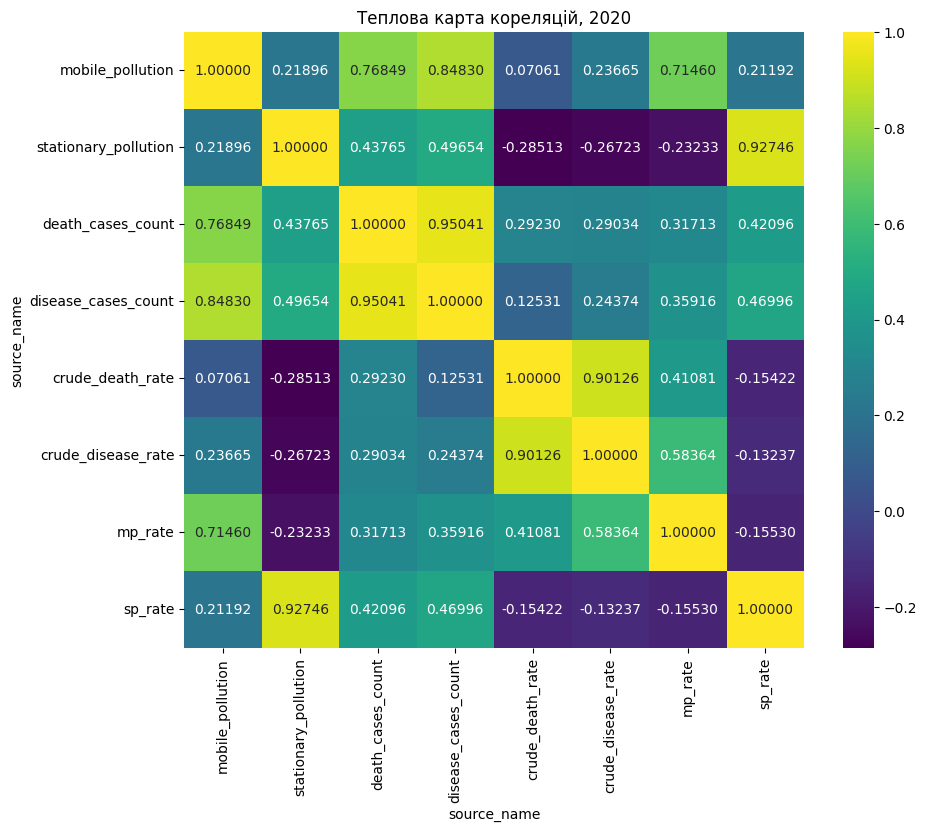

In [208]:
corr_matrix_2021_1 = df[df['year'] == 2021][selected_features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_2021_1, annot=True, cmap='viridis', fmt='.5f')
plt.title('Теплова карта кореляцій, 2020')
plt.show()

In [209]:
for feature in selected_features:
    pearson_corr(feature, 'crude_disease_rate', df[df['year'] == 2020])

mobile_pollution VS crude_disease_rate
Pearson: 0.27785
P-value: 0.17869
stationary_pollution VS crude_disease_rate
Pearson: -0.33229
P-value: 0.10462
death_cases_count VS crude_disease_rate
Pearson: 0.37725
P-value: 0.063017
disease_cases_count VS crude_disease_rate
Pearson: 0.34857
P-value: 0.087698
crude_death_rate VS crude_disease_rate
Pearson: 0.90442
P-value: 5.5922e-10
crude_disease_rate VS crude_disease_rate
Pearson: 1.00000
P-value: 0
mp_rate VS crude_disease_rate
Pearson: 0.64455
P-value: 0.00050552
sp_rate VS crude_disease_rate
Pearson: -0.19510
P-value: 0.35


Кореляція між mp_rate та crude_disease_rate є статистично значущою

<h1>Поліноміальна модель</h1>

In [213]:
from sklearn.preprocessing import PolynomialFeatures

rsqu_test = []
order = [1, 2, 3, 4, 5]

y1 = df['crude_disease_rate']
x1 = df[['mp_rate', 'sp_rate']]

x_test1, x_train1, y_test1, y_train1 = train_test_split(x1, y1, test_size=0.2)

print('Number of test samples: ', x_test1.shape[0])
print('Number of train samples: ', x_train1.shape[0])

Number of test samples:  40
Number of train samples:  10


Text(0.5, 1.0, 'R^2 моделей різних порядків')

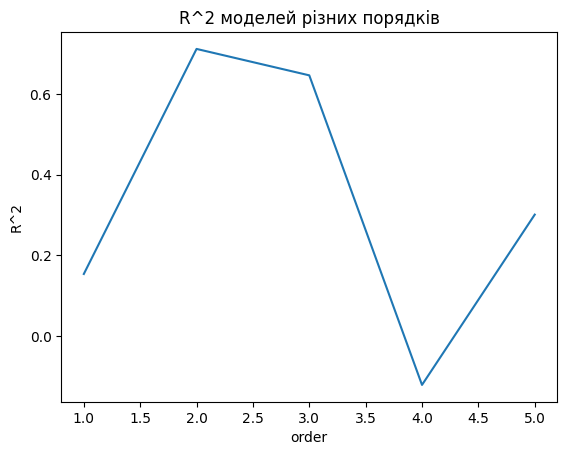

In [215]:
from sklearn.metrics import r2_score

for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train1[['mp_rate']])
    x_test_pr = pr.transform(x_test1[['mp_rate']])
    model3 = LinearRegression()
    model3.fit(x_train_pr, y_train1)
    y_test_pred = model3.predict(x_test_pr)
    rsqu_test.append(r2_score(y_test1, y_test_pred))

plt.plot(order, rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 моделей різних порядків')

Модель 2 другого порядку є найкращою. Після 3 ступеня спостерігається перенавчання

<h1>Random Forest</h1>

In [217]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth=5)
random_forest.fit(x_train1[['mp_rate']], y_train1)

RandomForestRegressor(max_depth=5)

In [218]:
random_forest_score = random_forest.score(x_test1[['mp_rate']], y_test1)
print('mean accuracy: ', random_forest_score)

mean accuracy:  0.44334755553599436
